# AGH Modelling of Physical Systems Lab 5 (2025 April 1st)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

In [ ]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [ ]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )

In [ ]:
def solve_upwind(*, nt: int, C: np.ndarray, psi: np.ndarray):
    i = slice(1, len(psi)-1)
    for _ in range(nt):
        upwind(psi, i, C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x, **kwargs):
    for label, data in kwargs.items():
        pyplot.step(x, data, label=label, where='mid')
    pyplot.legend()
    pyplot.grid()
    show_plot()

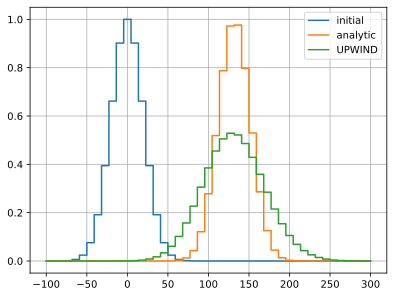

In [ ]:
u = 2
t_max = 66

nt = 100
dt = t_max / nt
nx=45
x, dx = np.linspace(-100, 300, num=nx, retstep=True)

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - u * t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(len(x)-1, u * dt / dx), psi=psi_0(x))
)

In [ ]:
def C_corr(psi, c, i):
    return (np.abs(c[i-hlf]) - c[i-hlf]**2) * (psi[i] - psi[i-one]) / (psi[i] + psi[i-one])

def corC(psi, c, i):
    return (np.abs(c[i-hlf]) - c[i-hlf]**2) * (psi[i] - psi[i-one]) / (psi[i] + psi[i-one])

def solve_mpdata(*, nt: int, C: float, psi: np.ndarray, num_of_corrections: int):
    i = slice(1, len(C))
    for _ in range(nt):
        upwind(psi, i, C)
        correctedC = corC(psi, C, slice(1, len(psi)))
        for _ in range(num_of_corrections):
            upwind(psi, i, correctedC)
            correctedC = corC(psi, correctedC, slice(1, len(psi)))

    return psi

In [ ]:
results = {}
psi = psi_0(x)

results["Init"] = psi
results["Anal"] = psi_0(x - u * t_max)

for i in range(8):
    results[f"{i} corr"] = solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi.copy(), num_of_corrections=i)

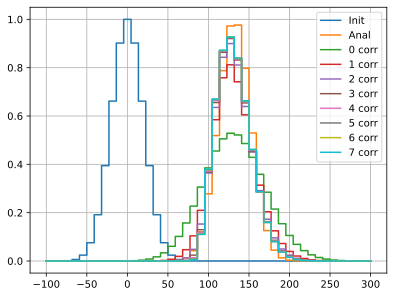

In [ ]:
for label, data in results.items():
    pyplot.step(x, data, label=label, where='mid')
pyplot.legend()
pyplot.grid()
pyplot.show()